Please refer to my [Medium article](https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114) for code explanations!!

# Load the required libraries

In [1]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# U-Net architecture

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


In [3]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [4]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)

        self.bottle_neck = DoubleConv(256, 512)

        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)

        b = self.bottle_neck(p3)

        up_2 = self.up_convolution_2(b, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [6]:
input_image = torch.rand((1,3,128,128))
model = UNet(3,10)
output = model(input_image)
print(output.size())
# You should get torch.Size([1, 10, 512, 512]) as a result

torch.Size([1, 10, 128, 128])


# Load the Carvana Dataset

In [7]:
class CarvanaDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train/")])[:self.limit]
        self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks/")])[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()])
        
        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask), self.images[index]

    def __len__(self):
        
        return min(len(self.images), self.limit)

In [9]:

print(os.listdir("./caravana/"))

DATASET_DIR = './caravana/'
WORKING_DIR = '.'

['train', 'train_masks']


In [10]:
train_dataset = CarvanaDataset(DATASET_DIR, limit=2000)

generator = torch.Generator().manual_seed(25)


In [11]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

In [12]:
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

In [13]:
device = "mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

In [37]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 128
out_checkpoint = 'my_checkpoint_small_2.pth'

In [38]:
train_dataloader = DataLoader(dataset=train_dataset,
                              pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Running the experiment

In [39]:

def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [40]:
torch.cuda.empty_cache()

In [41]:
EPOCHS = 10

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

# Guardar el modelo
torch.save(model.state_dict(), out_checkpoint)


 10%|█         | 1/10 [00:27<04:05, 27.31s/it]

------------------------------
Training Loss EPOCH 1: 0.5851
Training DICE EPOCH 1: 0.0000


Validation Loss EPOCH 1: 0.4620
Validation DICE EPOCH 1: 0.0000
------------------------------


 20%|██        | 2/10 [00:54<03:39, 27.49s/it]

------------------------------
Training Loss EPOCH 2: 0.4367
Training DICE EPOCH 2: 0.0000


Validation Loss EPOCH 2: 0.4197
Validation DICE EPOCH 2: 0.0003
------------------------------


 30%|███       | 3/10 [01:27<03:28, 29.72s/it]

------------------------------
Training Loss EPOCH 3: 0.3916
Training DICE EPOCH 3: 0.3008


Validation Loss EPOCH 3: 0.3545
Validation DICE EPOCH 3: 0.6736
------------------------------


 40%|████      | 4/10 [02:01<03:09, 31.52s/it]

------------------------------
Training Loss EPOCH 4: 0.3471
Training DICE EPOCH 4: 0.7084


Validation Loss EPOCH 4: 0.3115
Validation DICE EPOCH 4: 0.7494
------------------------------


 50%|█████     | 5/10 [02:34<02:39, 31.94s/it]

------------------------------
Training Loss EPOCH 5: 0.2775
Training DICE EPOCH 5: 0.7644


Validation Loss EPOCH 5: 0.2190
Validation DICE EPOCH 5: 0.8127
------------------------------


 60%|██████    | 6/10 [03:07<02:10, 32.50s/it]

------------------------------
Training Loss EPOCH 6: 0.1844
Training DICE EPOCH 6: 0.8107


Validation Loss EPOCH 6: 0.1637
Validation DICE EPOCH 6: 0.8387
------------------------------


 70%|███████   | 7/10 [03:40<01:37, 32.50s/it]

------------------------------
Training Loss EPOCH 7: 0.1484
Training DICE EPOCH 7: 0.8435


Validation Loss EPOCH 7: 0.1550
Validation DICE EPOCH 7: 0.8562
------------------------------


 80%|████████  | 8/10 [04:15<01:06, 33.24s/it]

------------------------------
Training Loss EPOCH 8: 0.1232
Training DICE EPOCH 8: 0.8760


Validation Loss EPOCH 8: 0.1091
Validation DICE EPOCH 8: 0.8969
------------------------------


 90%|█████████ | 9/10 [04:49<00:33, 33.55s/it]

------------------------------
Training Loss EPOCH 9: 0.1130
Training DICE EPOCH 9: 0.8900


Validation Loss EPOCH 9: 0.1106
Validation DICE EPOCH 9: 0.8980
------------------------------


100%|██████████| 10/10 [05:20<00:00, 32.05s/it]

------------------------------
Training Loss EPOCH 10: 0.0884
Training DICE EPOCH 10: 0.9149


Validation Loss EPOCH 10: 0.0809
Validation DICE EPOCH 10: 0.9230
------------------------------


# Results

In [42]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


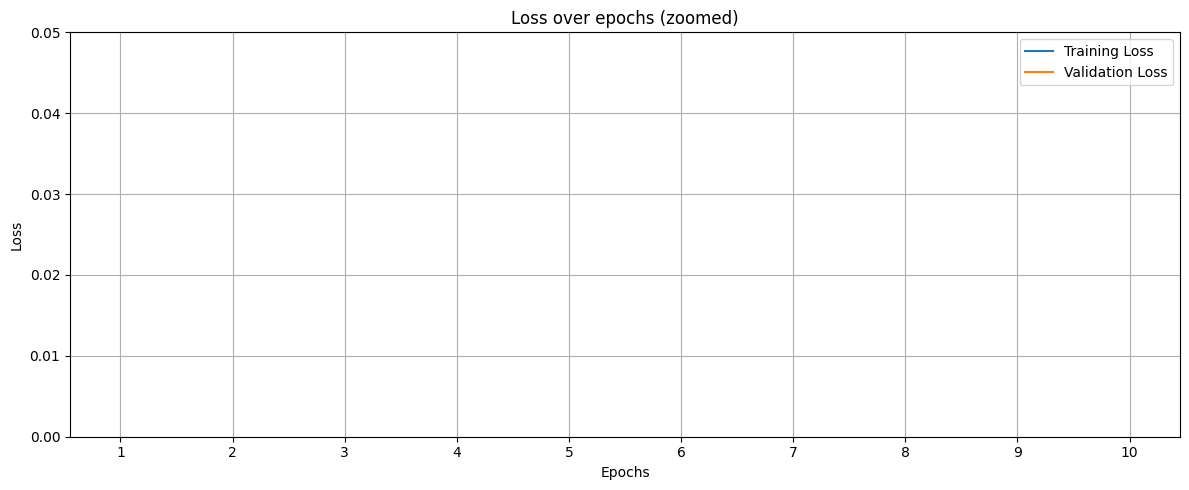

In [43]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.ylim(0, 0.05)
plt.title('Loss over epochs (zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()
plt.show()



In [44]:
model_pth = out_checkpoint
trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

/var/folders/rv/0brfn3g10137qh8fcq6ch2c00000gn/T/ipykernel_2091/1079796053.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model

<All keys matched successfully>

In [45]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


In [46]:
test_loss

0.07517241314053535

In [47]:
test_dc

0.9236942827701569

In [48]:
def random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device, flip=False):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    if flip:
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(p=1.0)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((128, 128))
        ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)
        
        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)
        
        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)),5)}")
        
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1
        
        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()


In [49]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 



/var/folders/rv/0brfn3g10137qh8fcq6ch2c00000gn/T/ipykernel_2091/2863992819.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, ma

Image: 1adaeb44f109_06.jpg, DICE coefficient: 0.94505


Image: 16f0ec26d608_05.jpg, DICE coefficient: 0.92143


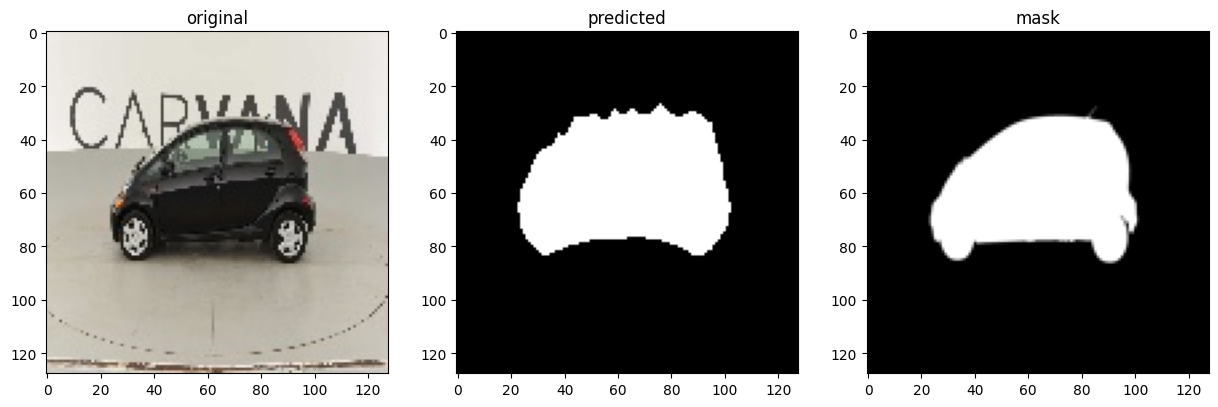

Image: 5ab34f0e3ea5_10.jpg, DICE coefficient: 0.92426


Image: 36a3f7f77e85_15.jpg, DICE coefficient: 0.94871


Image: 48b3f0c936b5_03.jpg, DICE coefficient: 0.93459


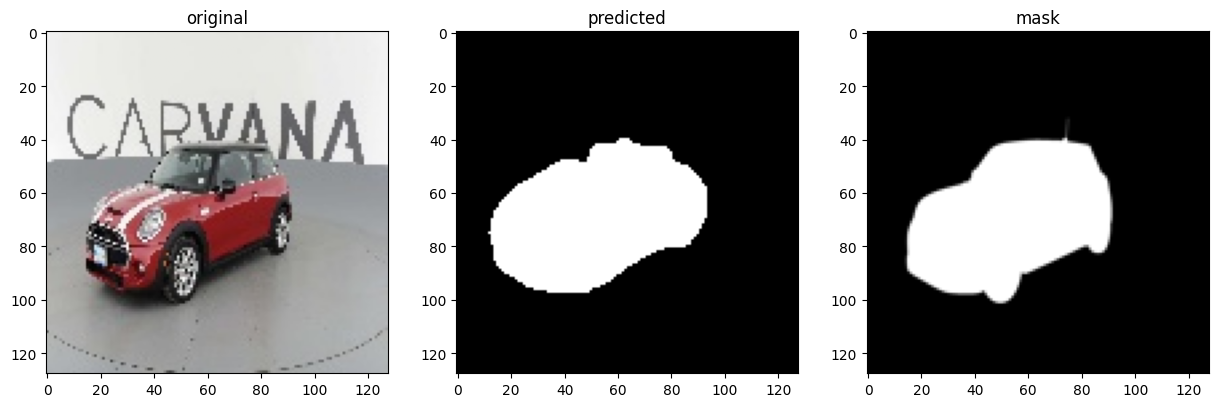

Image: 0ee135a3cccc_06.jpg, DICE coefficient: 0.94446


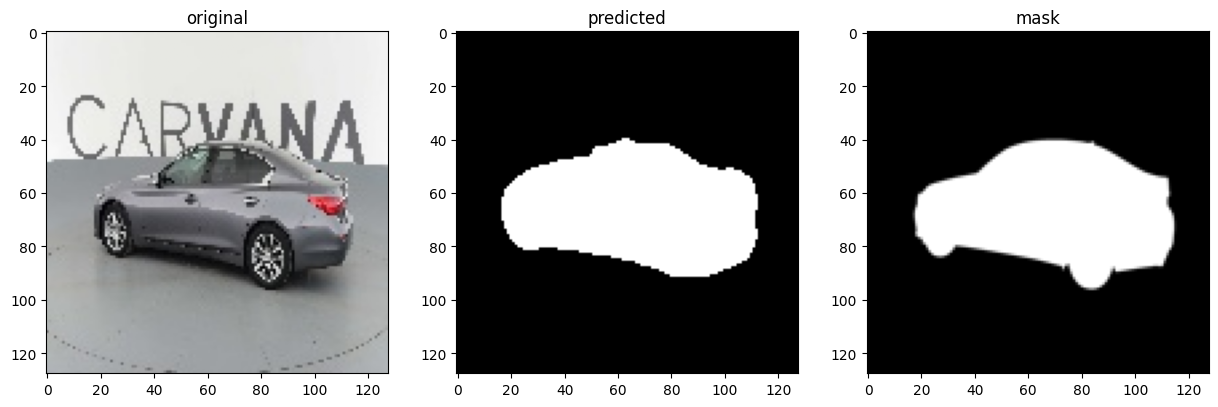

Image: 26ccab021981_09.jpg, DICE coefficient: 0.72678


Image: 4e7bc95552ed_02.jpg, DICE coefficient: 0.92787


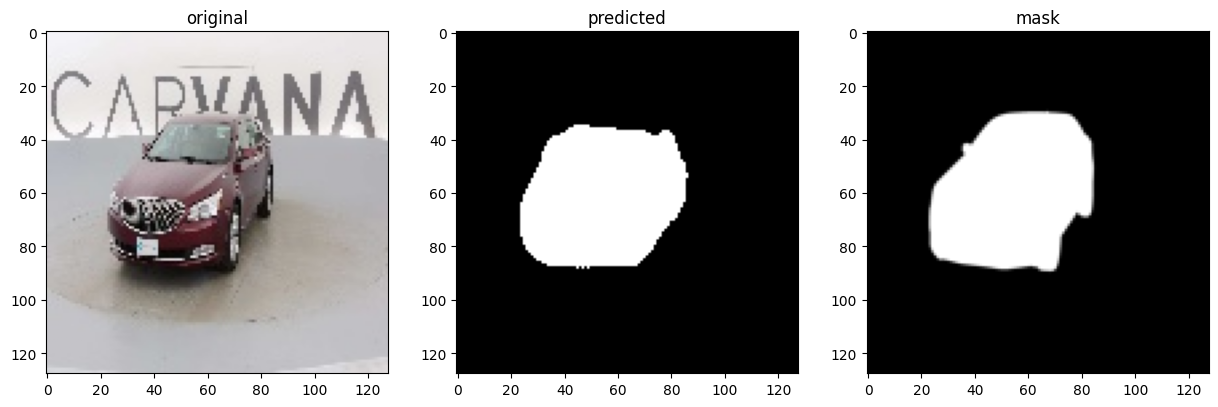

Image: 0ee135a3cccc_07.jpg, DICE coefficient: 0.91302


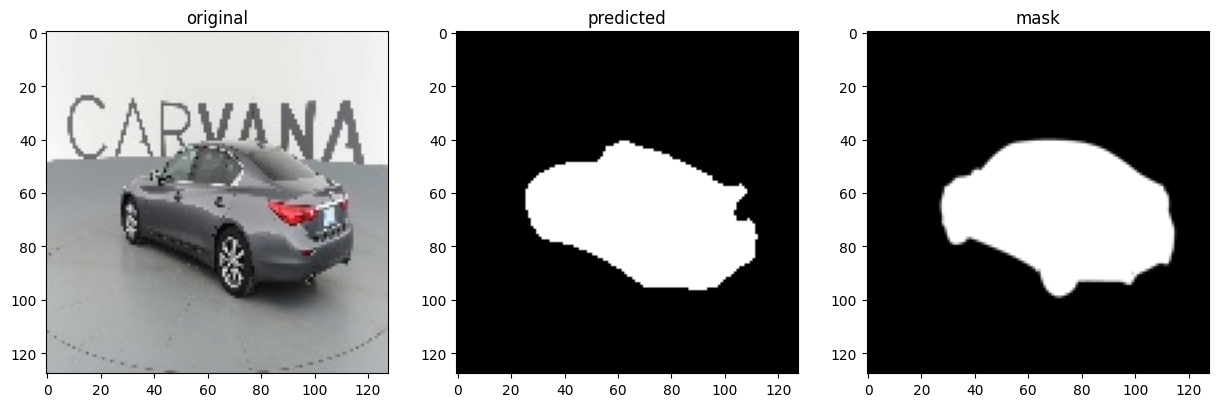

Image: 40851e617b93_03.jpg, DICE coefficient: 0.92169


In [50]:
model_path = out_checkpoint

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu")

# Optional: checking the masks in the training

/var/folders/rv/0brfn3g10137qh8fcq6ch2c00000gn/T/ipykernel_2091/2863992819.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, ma

Image: 31186febd775_16.jpg, DICE coefficient: 0.93975


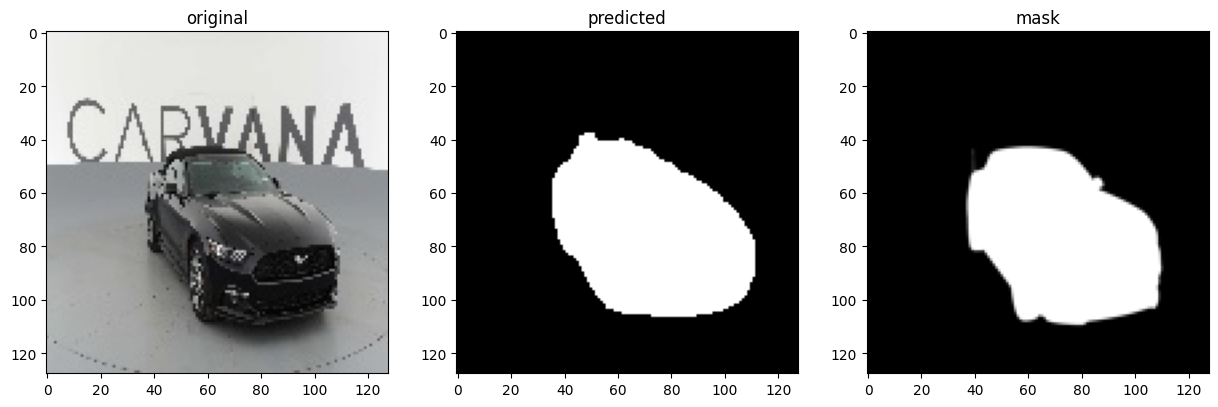

Image: 1a17a1bd648b_14.jpg, DICE coefficient: 0.96129


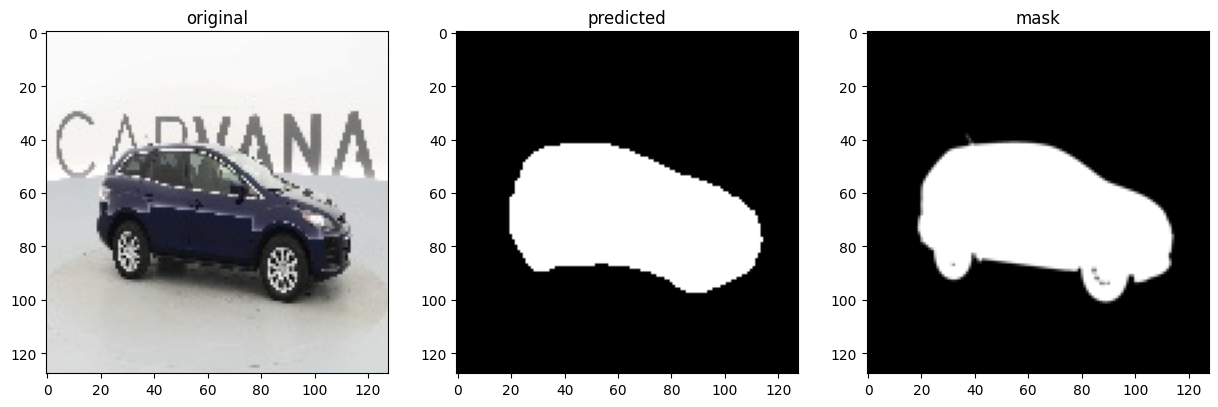

Image: 48b3f0c936b5_15.jpg, DICE coefficient: 0.93567


Image: 4dc8a7fe7c02_03.jpg, DICE coefficient: 0.86115


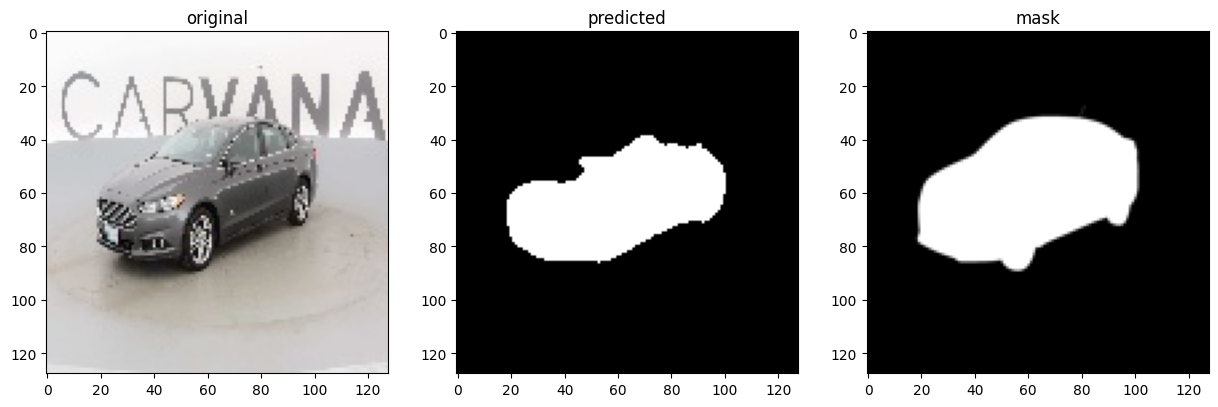

Image: 528eb34a4c29_08.jpg, DICE coefficient: 0.93768


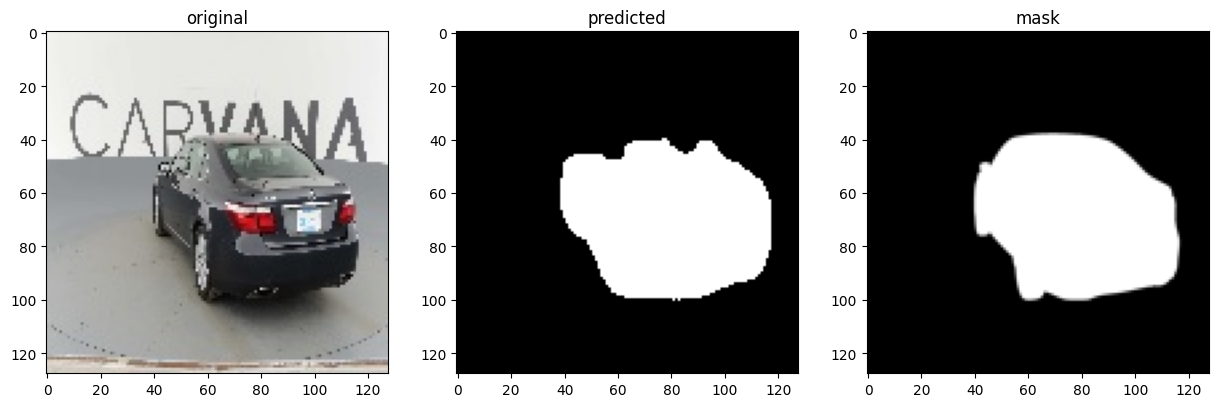

Image: 5ab34f0e3ea5_13.jpg, DICE coefficient: 0.92912


Image: 0495dcf27283_10.jpg, DICE coefficient: 0.90882


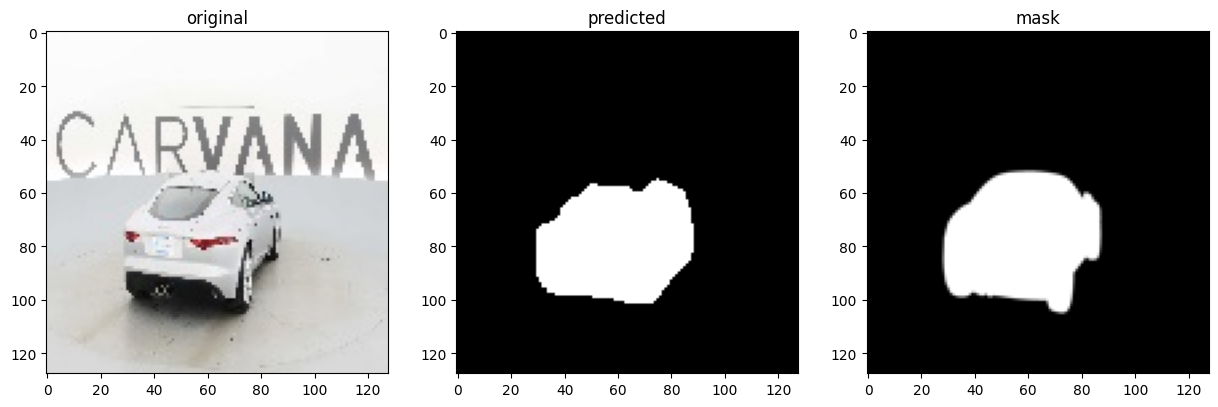

Image: 02159e548029_14.jpg, DICE coefficient: 0.9127


Image: 3810c5e1cdeb_08.jpg, DICE coefficient: 0.92787


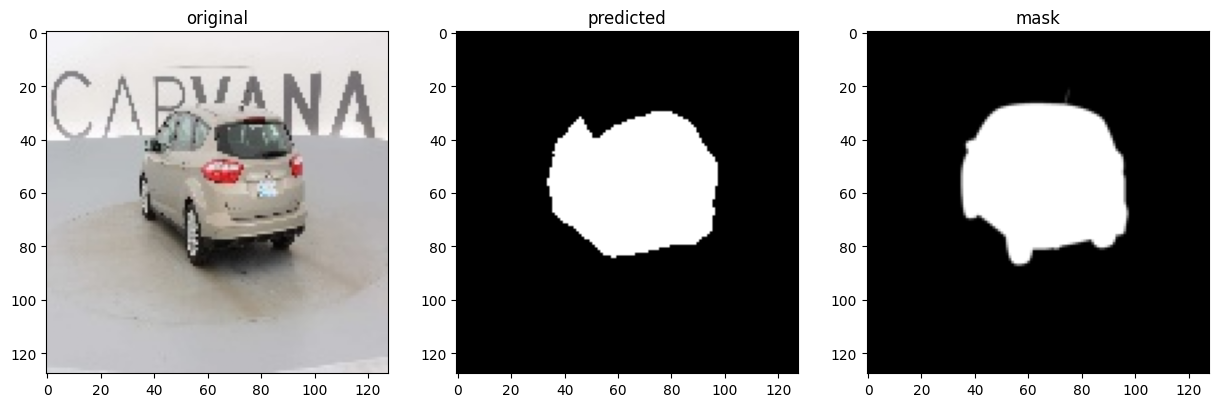

Image: 1390696b70b6_16.jpg, DICE coefficient: 0.95099


In [51]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu")

/var/folders/rv/0brfn3g10137qh8fcq6ch2c00000gn/T/ipykernel_2091/2863992819.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, ma

Image: 00087a6bd4dc_12.jpg, DICE coefficient: 0.93882


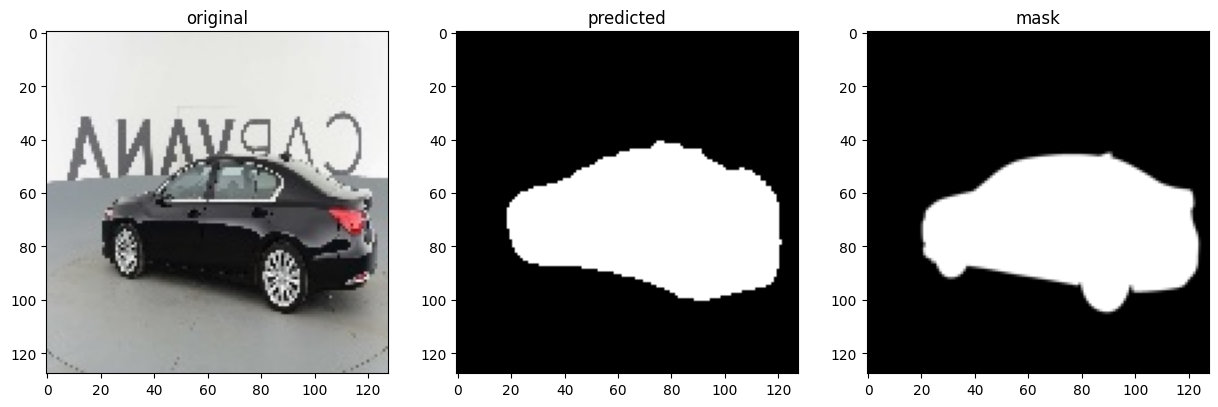

Image: 5bcde75955bb_09.jpg, DICE coefficient: 0.93138


Image: 344ece157efc_10.jpg, DICE coefficient: 0.9258


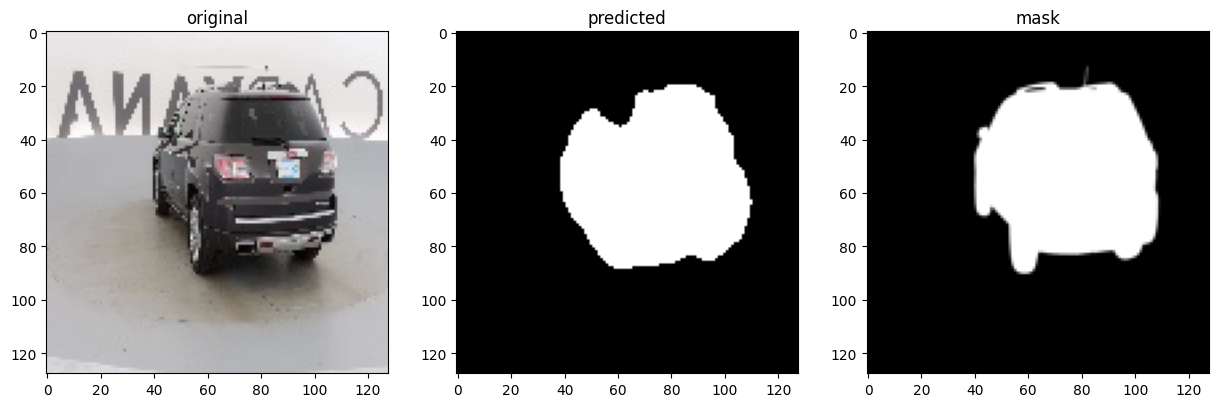

Image: 4dc8a7fe7c02_05.jpg, DICE coefficient: 0.93781


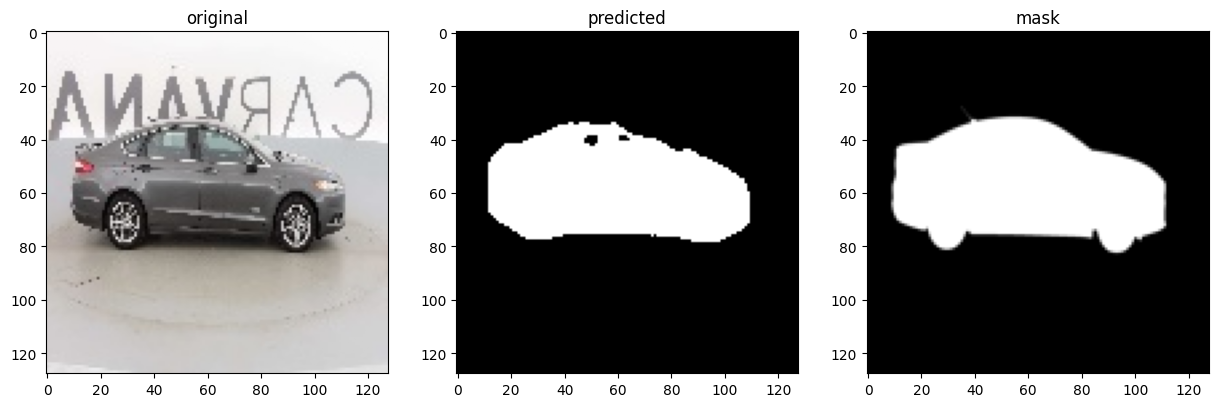

Image: 21a7e6726ee3_04.jpg, DICE coefficient: 0.9438


Image: 5ab34f0e3ea5_01.jpg, DICE coefficient: 0.94313


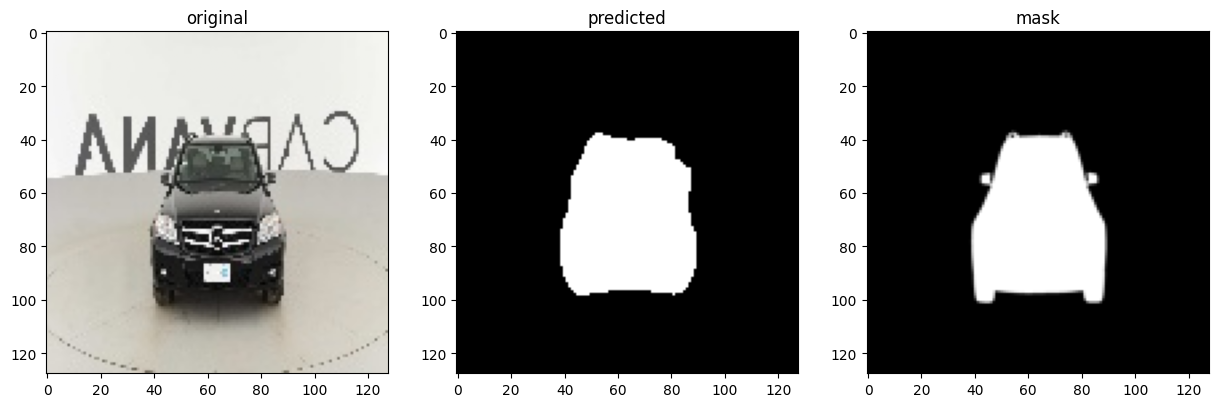

Image: 1390696b70b6_05.jpg, DICE coefficient: 0.92578


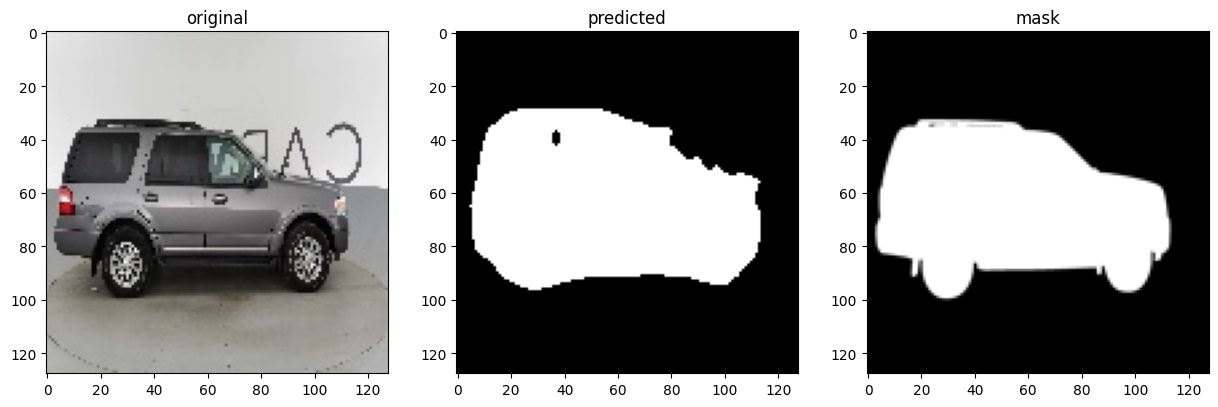

Image: 553c658b9efa_13.jpg, DICE coefficient: 0.93067


Image: 5bc30efeb7bf_13.jpg, DICE coefficient: 0.90832


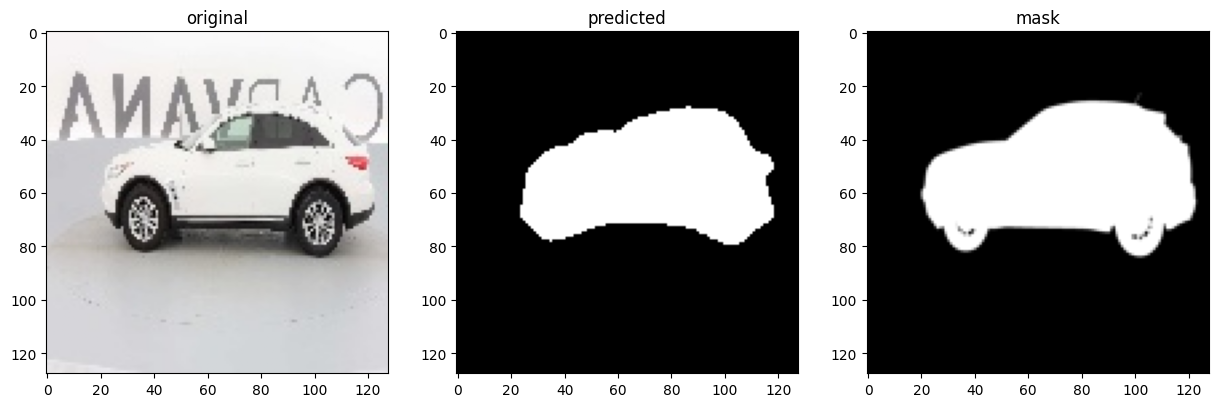

Image: 08a646be6b30_12.jpg, DICE coefficient: 0.93283


In [52]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu", flip=True)